In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

try:
    import mplfinance as mpf
except ImportError:
    print("The library is not yet installed. Installing it...")
    ! pip install mplfinance /dev/null 2>&1
    import mplfinance as mp
try:
    import yfinance as yf
except ImportError:
    print("The library is not yet installed. Installing it...")
    ! pip install yfinance /dev/null 2>&1
    import yfinance as yf

# Collecting and refining data

We can analyze data from a given dataset stored in memory

In [2]:
# casting the financial data of an arbitrary asset into a pd.DataFrame and performing some initial cleansing
def load_asset(name : str) -> pd.DataFrame :
  data = pd.read_csv(name, sep = "	")
  # data.index is to be interpreted as the time coordinate, measured in hours (hence points are separated by 0.25 h = 15 min)
  # this way, we eliminate the discontinuities in the time coordinate due to the weekend breaks
  data.index = np.arange(0, 0.25*len(data), 0.25)
  data["AbsTime"] = pd.to_datetime(data["<DATE>"] + " " + data["<TIME>"])
  data = data.drop("<TIME>",axis = 1)
  data = data.drop("<DATE>", axis = 1)
  data = data.drop("<TICKVOL>", axis = 1)
  data = data.drop("<SPREAD>", axis = 1)
  data = data.rename(columns = {"<OPEN>": "Open", "<CLOSE>": "Close", "<HIGH>": "High", "<LOW>":"Low", "<VOL>":"Vol" })
  return data

data_DAX = load_asset("DAX_M15_202005242300_202411131015.csv")
data_EURGBP = load_asset("EURGBP_M15_202012280930_202412311745.csv")
data_EURGBP.head(10)

,Open,High,Low,Close,Vol,AbsTime
0.00,0.90300,0.90364,0.90267,0.90351,0,2020-12-28 09:30:00
0.25,0.90350,0.90392,0.90329,0.90366,0,2020-12-28 09:45:00
0.50,0.90372,0.90502,0.90355,0.90380,0,2020-12-28 10:00:00
0.75,0.90381,0.90462,0.90340,0.90450,0,2020-12-28 10:15:00
1.00,0.90450,0.90480,0.90349,0.90414,0,2020-12-28 10:30:00
1.25,0.90416,0.90549,0.90412,0.90487,0,2020-12-28 10:45:00
1.50,0.90487,0.90550,0.90466,0.90526,0,2020-12-28 11:00:00
1.75,0.90526,0.90557,0.90476,0.90493,0,2020-12-28 11:15:00
2.00,0.90495,0.90557,0.90451,0.90484,0,2020-12-28 11:30:00
2.25,0.90483,0.90487,0.90369,0.90369,0,2020-12-28 11:45:00


Or, alternatively, download the dataset by means of the yfinance's python API

In [4]:
def download_asset(ticker_symbol : str, start : str, end : str) -> pd.DataFrame:
    # download the data from Yahoo Finance
    download_asset = yf.download(ticker_symbol, start=start, end=end)

    # adapt the dataframe to the previous format
    len_dataset = len(download_asset)
    deltaT = (download_asset.index[1] - download_asset.index[0]).total_seconds() / 3600   #in hours, for homogeneity
    data = pd.DataFrame({
        "Open": download_asset["Open"].values.reshape(len_dataset),
        "High": download_asset["High"].values.reshape(len_dataset),
        "Low": download_asset["Low"].values.reshape(len_dataset),
        "Close": download_asset["Close"].values.reshape(len_dataset),
        "Vol": download_asset["Volume"].values.reshape(len_dataset),
        "AbsTime" : download_asset.index
    })
    data.index = map(int,np.arange(0, deltaT*len(data), deltaT))
    return data

data_EURUSD = download_asset("EURUSD=X", start='2022-01-01',end='2024-10-01')
data_EURUSD.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Vol,AbsTime
0,1.137385,1.137592,1.128541,1.137346,0,2022-01-03
24,1.130199,1.132300,1.127345,1.130224,0,2022-01-04
48,1.128541,1.134559,1.127764,1.128363,0,2022-01-05
72,1.131222,1.133067,1.128554,1.131350,0,2022-01-06
96,1.129586,1.135976,1.129050,1.129688,0,2022-01-07
120,1.135344,1.135976,1.128834,1.135396,0,2022-01-10
144,1.133273,1.136900,1.131554,1.133042,0,2022-01-11
168,1.137010,1.143300,1.135576,1.136648,0,2022-01-12
192,1.143981,1.147908,1.143641,1.144165,0,2022-01-13
216,1.145659,1.148369,1.141005,1.145712,0,2022-01-14


### A first naive plot for the dataset

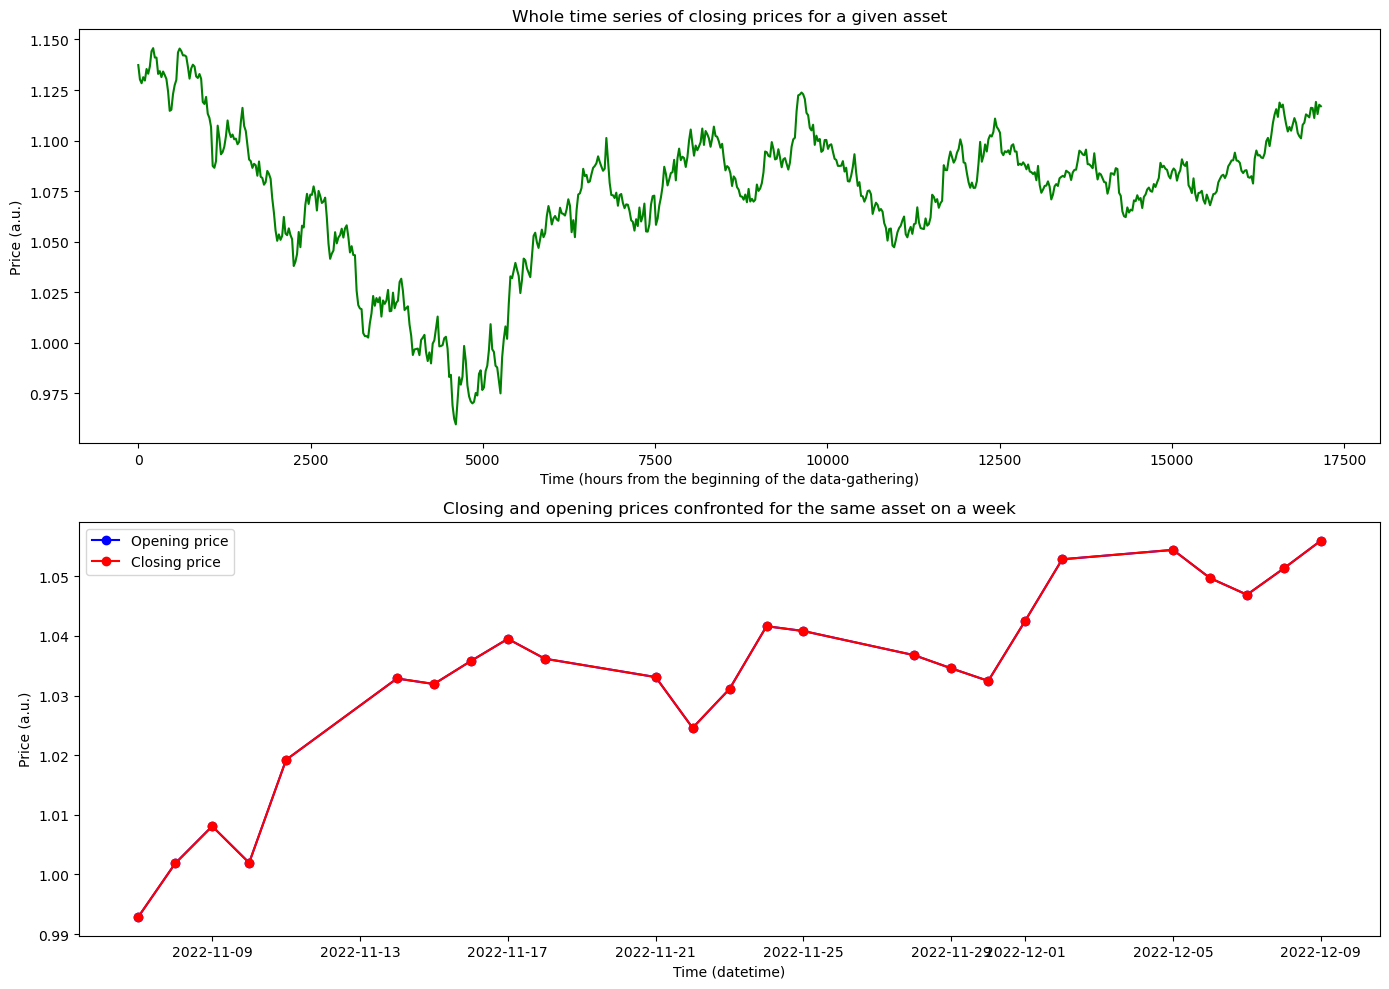

<Axes: title={'center': 'Closing and opening prices confronted for the same asset on a week'}, xlabel='Time (datetime)', ylabel='Price (a.u.)'>

In [5]:
def draw_info(start : str, end : str, data : pd.DataFrame):
    # One can visualize the time series in a naive way by simply plotting the closing price as a function of time
    fig, ax = plt.subplots(ncols = 1, nrows = 2, figsize=(14,10))
    ax[0].plot(data.index, data["Close"], c = "g")
    ax[0].set_title("Whole time series of closing prices for a given asset")
    ax[0].set_xlabel("Time (hours from the beginning of the data-gathering)")
    ax[0].set_ylabel("Price (a.u.)")

    # A zoomed view of the same dataset reveals the small differences between closing and opening prices
    # N.B. the plot shows discontinuities due to the weekend breaks, but that's only cause I'm plotting against the columns "AbsTime"
    # which is a datetime object. The actual time coordinate is the index of the DataFrame, which is continuous (and that's what we'll use)
    # Just for this picture, I thought it would have been more meaningful to plot against the datetime object
    filtered_data = data[(data["AbsTime"] > start) & (data["AbsTime"] < end)]
    ax[1].plot(filtered_data["AbsTime"].values, filtered_data["Open"].values, "b", marker = "o", label = "Opening price")
    ax[1].plot(filtered_data["AbsTime"].values, filtered_data["Close"].values, "r", marker = "o", label = "Closing price")
    ax[1].set_title("Closing and opening prices confronted for the same asset on a week")
    ax[1].legend(loc = "best")
    ax[1].set_xlabel("Time (datetime)")
    ax[1].set_ylabel("Price (a.u.)")

    fig.tight_layout()
    plt.show()
    return ax[1]
draw_info("2022-11-4", "2022-12-10", data_EURUSD)

### Using a candlestick representation

When it comes to financial dataset, it is often useful to visualize those data by means of _ohlc plots_ or _candlestick plots_. We'll use the `mpflfinance` library

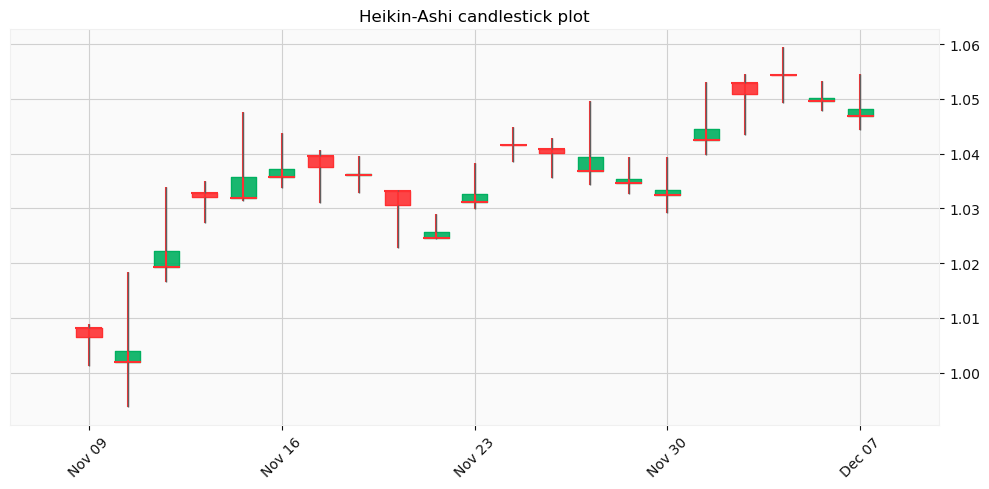

In [6]:
# returns a new pd.DataFrame where assets data are interpreted according to Heikin-Ashi candlestick representation
def calculate_heikin_ashi(df):
    ha = df.copy()
    ha['HA_open'] = (df['Open'] + df['Close']) / 2
    ha['HA_high'] = df[['High', 'Open', 'Close']].max(axis=1)
    ha['HA_low'] = df[['Low', 'Open', 'Close']].min(axis=1)
    ha['HA_close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
    return ha[["HA_open", "HA_close", "HA_high", "HA_low"]].rename(columns = {"HA_open":"Open", "HA_close": "Close", "HA_low": "Low", "HA_high":"High"})

#candlestick OHLC plot
def plot_OHLC(start : str, end : str, data : pd.DataFrame):
  fig = mpf.figure(style="yahoo", figsize =(10 , 5))
  ax = fig.add_subplot(1, 1, 1)

  ohlc_data = data[(data["AbsTime"] >start) & (data["AbsTime"] < end)].copy()[["Open", "Close", "High", "Low", "AbsTime"]]
  ax.set_title("OHLC candlestick plot")
  #unfortunately, the built-in function mpf.plot wants as indices datetime objects, so we have to convert them first
  ohlc_data.index = ohlc_data["AbsTime"]
  mpf.plot(ohlc_data, type= "candle", volume=False, ylabel="", ax=ax)
  plt.tight_layout()
  plt.show()


#plot a simple OHLC plot and superimpose the Heikin-Ashi candles
def plot_OHLC_HA(start : dt.datetime, end : dt.datetime, data : pd.DataFrame):
  fig = mpf.figure(style="yahoo", figsize =(10 , 5))
  ax = fig.add_subplot(1, 1, 1)

  ohlc_data = data[(data["AbsTime"] >start) & (data["AbsTime"] < end)].copy()[["Open", "Close", "High", "Low", "AbsTime"]]
  ohlc_data.index = ohlc_data["AbsTime"]
  ha_data = calculate_heikin_ashi(ohlc_data)

  addplot = [
        mpf.make_addplot(ha_data, type="candle", secondary_y=False, ax=ax),
  ]
  ax.set_title("Heikin-Ashi candlestick plot")


  mpf.plot(ohlc_data, type= "ohlc", volume=False, ylabel="", ax=ax, addplot = addplot)
  plt.tight_layout()
  plt.show()

plot_OHLC_HA("2022-11-8", "2022-12-8", data_EURUSD)

# Step 1: isolating and removing the medium-term linear trend

In [7]:
from scipy.optimize import curve_fit

# this function takes as input a dataframe (formatted as above) and a mesh, basically a partition of the time coordinate (e.g. (1, 5, 8, ..., 124)
# where 124 is the len(dataset)
# The function then splits the original dataset based on the mesh and performs a linear fit on each partition. The linear trend is then removed
# It returns a list of pd.Series, each one containing the cleaned data (original - linear fit)
def removeTrend(dataset : pd.DataFrame, mesh : np.array, ax = None) -> np.array:
    l = []
    for i in range(len(mesh)-1):
        r = (int(mesh[i]), int(mesh[i+1]))
        # resized dataset
        curr_dataset = dataset.iloc[r[0]:r[1]]["Close"].copy() # do we need to copy? To be addressed later
        # performing the linear fit
        def linear_fit(x, a, b):
            return a*x + b
        popt, pcov = curve_fit(linear_fit, curr_dataset.index, curr_dataset.values, p0 = [0,0])  # work on the initial guess !
        #arr[i] = popt[0]
        if (ax is not None):
            ax.plot(np.linspace(curr_dataset.index[0],curr_dataset.index[-1], 1000 ), linear_fit(np.linspace(curr_dataset.index[0],curr_dataset.index[-1], 1000 ), *popt), "r")
        cleaned_data = curr_dataset - linear_fit(curr_dataset.index, *popt)
        l.append(cleaned_data)
    return l

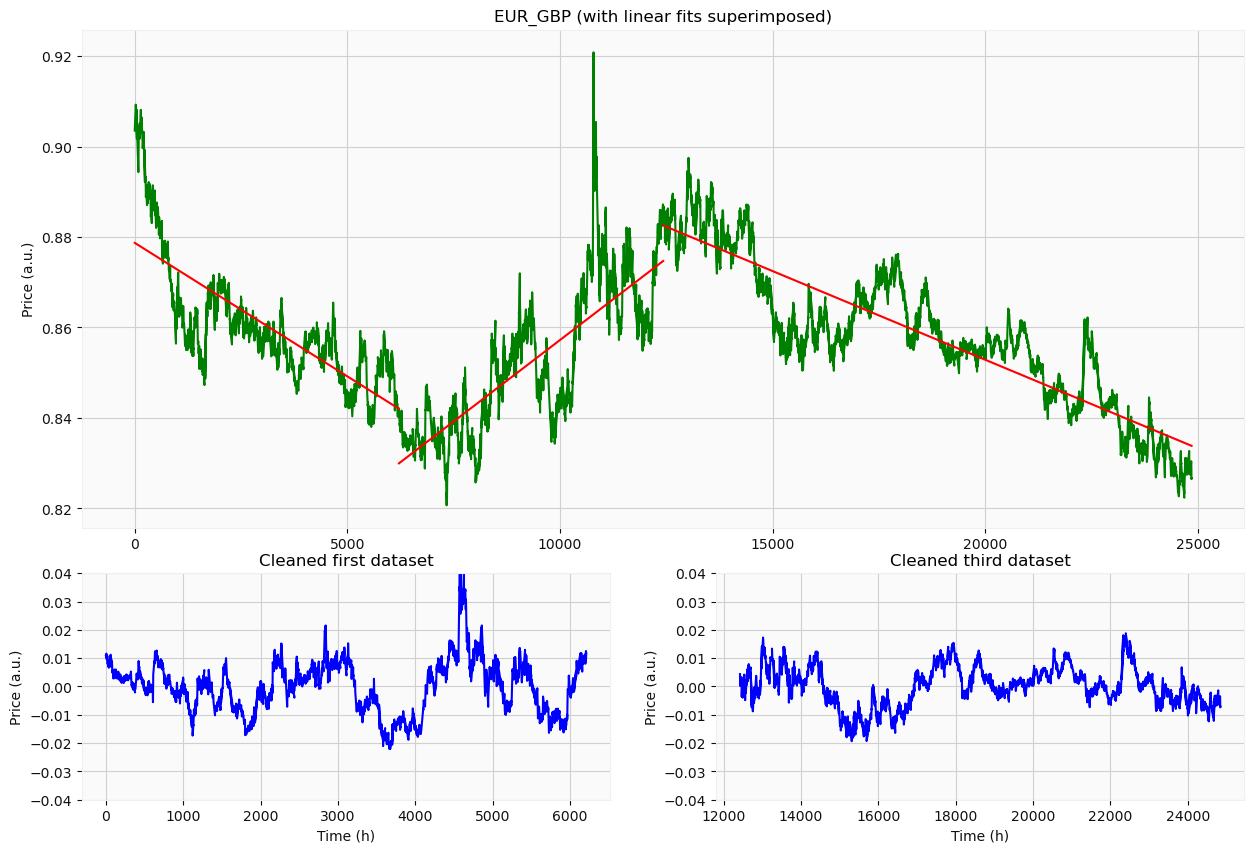

In [163]:
# Let's see it in action. We'll draw an usual plot of closing prices ...
df, name = data_EURGBP, "EUR_GBP"
gridsize = (3,2)
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid(gridsize, (0,0), colspan=2, rowspan=2)
ax1.plot(df.index, df["Close"], c = "g")
ax1.set_title(name + " (with linear fits superimposed)")
#ax1.set_xlabel("Time (hours from the beginning of the data-gathering)")
ax1.set_ylabel("Price (a.u.)")

# and perform the removal of the trend. Passing ax as an optional argument, we can superimpose the linear fits to visually see the fitting line
#mesh = np.linspace(0, len(data_EURGBP), 5)   # an uniform mesh
mesh2 = np.array([0,int(len(df)/4), int(len(df)/2), int(len(df))])
arr = removeTrend(df, mesh2, ax1)

ax2 = plt.subplot2grid(gridsize, (2,0), colspan=1, rowspan=1)
ax2.plot(arr[0].index, arr[1].values, c = "b")
ax2.set_title("Cleaned first dataset")
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Price (a.u.)")
ax2.set_ylim(-0.04, 0.04)

ax3 = plt.subplot2grid(gridsize, (2,1), colspan=1, rowspan=1)
ax3.plot(arr[2].index, arr[2].values, c = "b")
ax3.set_title("Cleaned third dataset")
ax3.set_xlabel("Time (h)")
ax3.set_ylabel("Price (a.u.)")
ax3.set_ylim(-0.04, 0.04)

plt.tight_layout
plt.show()

Mu: -1.170746683903616e-05, Std: 0.006869534390456241


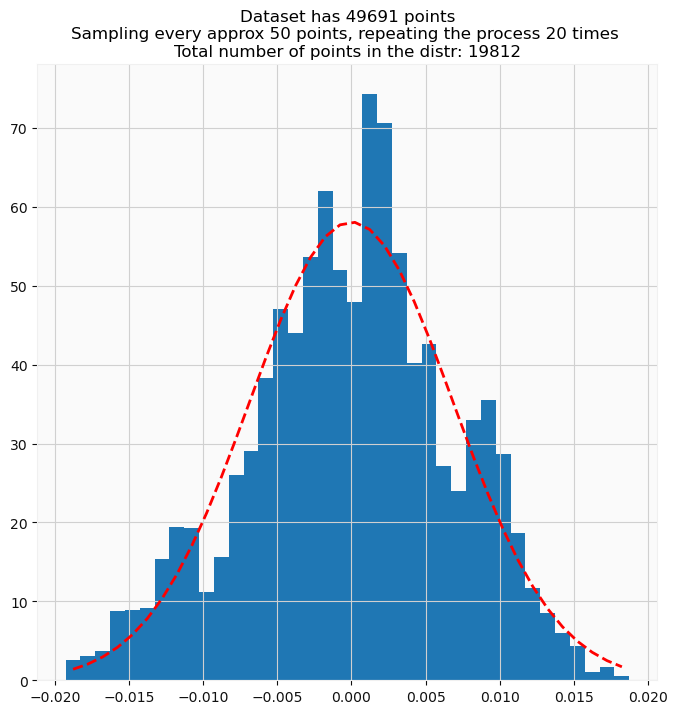

In [182]:
from scipy.stats import norm
from math import pi

# We want to study the distribution of points in a certain dataset.
# If the process, for example, is stationary (OU-like), we expect the distribution to be gaussian
# We can't select neighbouring points, as they are correlated, so we have to sample the dataset every lambda points approximately
# (formally, a distanca d which is higher then the decorrelation time of the process)
# To make this statistic more robust, we can repeat the process multiple times choosing different sampling of the dataset and average the resulting distribution

## WIP !!! what if we chose a gaussian sampling? (The distance between two points is gaussian distributed)
def plot_distribution(dataset : pd.Series, lambda_ : int, n : int):

    x = np.array([0])
    # repeat the process n times
    for i in range(n):
        # we will sample the dataset choosing a value every lambda points on average (poisson distr)
        choice = [np.random.randint(lambda_)]  #choice is the vector of indices of chosen values
        for i in range(1, int(len(dataset)/lambda_) ):
            l = np.random.poisson(lambda_)
            if (int(choice[-1]+l) > len(dataset)-1):
                break
            choice.append(int(choice[-1]+l))
        #filtered data, chosen approx every lambda points
        chosen_data = (dataset.values)[choice]
        x = np.concatenate((x,chosen_data), axis = 0)

    fig, ax = plt.subplots(figsize=(8,8))
    bin_edges = np.arange(np.min(x), np.max(x), 0.001)
    ax.hist(x, bins = bin_edges, density=True)
    ax.set_title(f"Dataset has {len(dataset)} points"+ '\n'+f"Sampling every approx {lambda_} points, repeating the process {n} times " + '\n' + f"Total number of points in the distr: {len(x)}" )

    mu, std = norm.fit(x)
    print(f"Mu: {mu}, Std: {std}")

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    ax.plot(bin_centers, norm.pdf(bin_centers, mu, std), 'r--', linewidth=2)

plot_distribution(arr[2], 50,20)
              